# TMDB Code
- Amber Kutscher
- 09.19.2023
- Data Enrichment

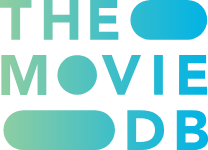

Data Source: https://datasets.imdbws.com

## Data Dictionary

**title.akas.tsv.gz**
- titleId (string) - a tconst, an alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- title (string) – the localized title
- region (string) - the region for this version of the title
- language (string) - the language of the title
- types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
- attributes (array) - Additional terms to describe this alternative title, not enumerated
- isOriginalTitle (boolean) – 0: not original title; 1: original title

**title.basics.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title

**title.ratings.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

In [1]:
# Install tmdbsimple (only need to run once)
!pip install tmdbsimple

In [6]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
pymysql.install_as_MySQLdb()
from urllib.parse import quote_plus as urlquote

# Additional Imports
import os, json, math, time, gzip, csv
from yelpapi import YelpAPI
from tqdm.notebook import tqdm_notebook
import tmdbsimple as tmdb

In [3]:
# Load dataset URLs
# basics_url = "https://datasets.imdbws.com/title.basics.tsv.gz"
# ratings_url = "https://datasets.imdbws.com/title.ratings.tsv.gz"

In [4]:
# Read in the datasets    
# basics = pd.read_csv(basics_url, sep='\t', low_memory=False)
# ratings = pd.read_csv(ratings_url, sep='\t', low_memory=False)

In [9]:
# Read in the akas dataset
with gzip.open('Data/title-akas-us-only.csv', 'rb') as f:
    akas = pd.read_csv(f, encoding='utf-8', low_memory=False)

akas.head()

titleId  ordering                   title region language        types  \
0  tt0000001         6              Carmencita     US      NaN  imdbDisplay   
1  tt0000002         7  The Clown and His Dogs     US      NaN          NaN   
2  tt0000005        10        Blacksmith Scene     US      NaN  imdbDisplay   
3  tt0000005         1     Blacksmithing Scene     US      NaN  alternative   
4  tt0000005         6     Blacksmith Scene #1     US      NaN  alternative   

              attributes  isOriginalTitle  
0                    NaN              0.0  
1  literal English title              0.0  
2                    NaN              0.0  
3                    NaN              0.0  
4                    NaN              0.0

In [34]:
# Open saved basics file and preview again
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
basics.head()

tconst titleType                                       primaryTitle  \
0  tt0035423     movie                                     Kate & Leopold   
1  tt0062336     movie  The Tango of the Widower and Its Distorting Mi...   
2  tt0068865     movie                                Lives of Performers   
3  tt0069049     movie                         The Other Side of the Wind   
4  tt0088751     movie                                  The Naked Monster   

                               originalTitle  isAdult  startYear  endYear  \
0                             Kate & Leopold        0     2001.0      NaN   
1  El tango del viudo y su espejo deformante        0     2020.0      NaN   
2                        Lives of Performers        0     2016.0      NaN   
3                 The Other Side of the Wind        0     2018.0      NaN   
4                          The Naked Monster        0     2005.0      NaN   

   runtimeMinutes                  genres  
0             118  Comedy,Fantasy,Romance  
1              70                   Drama  
2              90                   Drama  
3             122                   Drama  
4             100    Comedy,Horror,Sci-Fi

In [35]:
# Open saved ratings file and preview again
ratings = pd.read_csv("Data/title_ratings.csv.gz", low_memory = False)
ratings.head()

tconst  averageRating  numVotes
0  tt0035423            6.4     87623
1  tt0062336            6.4       180
2  tt0068865            5.4        74
3  tt0069049            6.7      7834
4  tt0088751            5.3       341

In [12]:
# Preview first 5 rows of akas dataset
akas.head()

titleId  ordering                   title region language        types  \
0  tt0000001         6              Carmencita     US      NaN  imdbDisplay   
1  tt0000002         7  The Clown and His Dogs     US      NaN          NaN   
2  tt0000005        10        Blacksmith Scene     US      NaN  imdbDisplay   
3  tt0000005         1     Blacksmithing Scene     US      NaN  alternative   
4  tt0000005         6     Blacksmith Scene #1     US      NaN  alternative   

              attributes  isOriginalTitle  
0                    NaN              0.0  
1  literal English title              0.0  
2                    NaN              0.0  
3                    NaN              0.0  
4                    NaN              0.0

In [13]:
# Preview first 5 rows of basics dataset
basics.head()

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short

In [14]:
# Preview first 5 rows of ratings dataset
ratings.head()

tconst  averageRating  numVotes
0  tt0000001            5.7      1994
1  tt0000002            5.8       268
2  tt0000003            6.5      1883
3  tt0000004            5.5       177
4  tt0000005            6.2      2667

In [15]:
# Make a copy of akas_us
akas_copy = akas.copy()

In [16]:
# Replace "\N" with np.nan and verify that it stuck
akas_copy.replace({'\\N':np.nan}, inplace=True)
akas_copy.head()

titleId  ordering                   title region language        types  \
0  tt0000001         6              Carmencita     US      NaN  imdbDisplay   
1  tt0000002         7  The Clown and His Dogs     US      NaN          NaN   
2  tt0000005        10        Blacksmith Scene     US      NaN  imdbDisplay   
3  tt0000005         1     Blacksmithing Scene     US      NaN  alternative   
4  tt0000005         6     Blacksmith Scene #1     US      NaN  alternative   

              attributes  isOriginalTitle  
0                    NaN              0.0  
1  literal English title              0.0  
2                    NaN              0.0  
3                    NaN              0.0  
4                    NaN              0.0

In [17]:
# Keep only US movies in the basics dataframe
basics_keepers = basics['tconst'].isin(akas_copy['titleId'])
basics_filtered = basics[basics_keepers]
basics_filtered

tconst titleType                                 primaryTitle  \
0         tt0000001     short                                   Carmencita   
1         tt0000002     short                       Le clown et ses chiens   
4         tt0000005     short                             Blacksmith Scene   
5         tt0000006     short                            Chinese Opium Den   
6         tt0000007     short  Corbett and Courtney Before the Kinetograph   
...             ...       ...                                          ...   
10194252  tt9916560   tvMovie    March of Dimes Presents: Once Upon a Dime   
10194281  tt9916620     movie                            The Copeland Case   
10194319  tt9916702     short                Loving London: The Playground   
10194342  tt9916756     short                     Pretty Pretty Black Girl   
10194346  tt9916764     short                                           38   

                                        originalTitle isAdult startYear  \
0                                          Carmencita       0      1894   
1                              Le clown et ses chiens       0      1892   
4                                    Blacksmith Scene       0      1893   
5                                   Chinese Opium Den       0      1894   
6         Corbett and Courtney Before the Kinetograph       0      1894   
...                                               ...     ...       ...   
10194252    March of Dimes Presents: Once Upon a Dime       0      1963   
10194281                            The Copeland Case       0        \N   
10194319                Loving London: The Playground       0        \N   
10194342                     Pretty Pretty Black Girl       0      2019   
10194346                                           38       0      2018   

         endYear runtimeMinutes             genres  
0             \N              1  Documentary,Short  
1             \N              5    Animation,Short  
4             \N              1       Comedy,Short  
5             \N              1              Short  
6             \N              1        Short,Sport  
...          ...            ...                ...  
10194252      \N             58             Family  
10194281      \N             \N              Drama  
10194319      \N             \N        Drama,Short  
10194342      \N             \N              Short  
10194346      \N             \N              Short  

[1364895 rows x 9 columns]

In [18]:
# Make a copy of basics_filtered
basics_filtered_copy = basics_filtered.copy()

In [19]:
# Replace "\N" with np.nan and verify that it stuck
basics_filtered_copy.replace({'\\N':np.nan}, inplace=True)
basics_filtered_copy.head()

tconst titleType                                 primaryTitle  \
0  tt0000001     short                                   Carmencita   
1  tt0000002     short                       Le clown et ses chiens   
4  tt0000005     short                             Blacksmith Scene   
5  tt0000006     short                            Chinese Opium Den   
6  tt0000007     short  Corbett and Courtney Before the Kinetograph   

                                 originalTitle isAdult startYear endYear  \
0                                   Carmencita       0      1894     NaN   
1                       Le clown et ses chiens       0      1892     NaN   
4                             Blacksmith Scene       0      1893     NaN   
5                            Chinese Opium Den       0      1894     NaN   
6  Corbett and Courtney Before the Kinetograph       0      1894     NaN   

  runtimeMinutes             genres  
0              1  Documentary,Short  
1              5    Animation,Short  
4              1       Comedy,Short  
5              1              Short  
6              1        Short,Sport

In [20]:
# Eliminate movies that are null for runtimeMinutes
# Eliminate movies that are null for genre
basics_filtered_copy = basics_filtered_copy.dropna(subset=['runtimeMinutes', 'genres'])

In [21]:
# Keep only titleType==Movie
basics_filtered_copy = basics_filtered_copy[basics_filtered_copy['titleType'] == 'movie']

In [22]:
# Convert the startYear column to float data type.
basics_filtered_copy['startYear'] = basics_filtered_copy['startYear'].astype(float)

In [23]:
# Filter the dataframe using startYear. Keep years between 2000-2021 (Including 2000 and 2021)
basics_filtered_copy = basics_filtered_copy[(basics_filtered_copy['startYear'] 
                                             >= 2000) & (basics_filtered_copy
                                                         ['startYear'] <= 2021)]

In [24]:
# Filter the ratings DataFrame based on tconst from basics_filtered_copy
ratings_filtered = ratings[ratings['tconst'].isin(basics_filtered_copy['tconst'])]

In [25]:
# Make a copy of ratings_filtered
ratings_filtered_copy = ratings_filtered.copy()

In [26]:
# Replace "\N" with np.nan in the ratings DataFrame
ratings_filtered_copy.replace({'\\N':np.nan}, inplace=True)
ratings_filtered_copy.head()

tconst  averageRating  numVotes
17924  tt0035423            6.4     87623
40688  tt0062336            6.4       180
46402  tt0068865            5.4        74
46559  tt0069049            6.7      7834
63525  tt0088751            5.3       341

In [27]:
# Run a final .info() on akas_us_copy dataframe
akas_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452564 entries, 0 to 1452563
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   titleId          1452564 non-null  object 
 1   ordering         1452564 non-null  int64  
 2   title            1452564 non-null  object 
 3   region           1452564 non-null  object 
 4   language         4018 non-null     object 
 5   types            981678 non-null   object 
 6   attributes       47016 non-null    object 
 7   isOriginalTitle  1451222 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 88.7+ MB


In [28]:
# Run a final .info() on basics_filtered_copy dataframe
basics_filtered_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114448 entries, 34800 to 10194157
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          114448 non-null  object 
 1   titleType       114448 non-null  object 
 2   primaryTitle    114448 non-null  object 
 3   originalTitle   114448 non-null  object 
 4   isAdult         114448 non-null  object 
 5   startYear       114448 non-null  float64
 6   endYear         0 non-null       object 
 7   runtimeMinutes  114448 non-null  object 
 8   genres          114448 non-null  object 
dtypes: float64(1), object(8)
memory usage: 8.7+ MB


In [29]:
# Run a final .info() on ratings_filtered_copy dataframe
ratings_filtered_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87571 entries, 17924 to 1353341
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         87571 non-null  object 
 1   averageRating  87571 non-null  float64
 2   numVotes       87571 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


In [30]:
# Save akas_us_copy dataframe to csv file
akas_copy.to_csv("Data/title-akas-us-only.csv", compression='gzip', index=False)

In [31]:
# Save basics_filtered_copy dataframe to csv file
basics_filtered_copy.to_csv("Data/title_basics.csv.gz", compression='gzip', index=False)

In [32]:
# Save ratings_us_copy dataframe to csv file
ratings_filtered_copy.to_csv("Data/title_ratings.csv.gz", compression='gzip', index=False)